In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import tensorflow as tf
import warnings

warnings.filterwarnings('ignore')
plt.rc('font', family='AppleGothic')

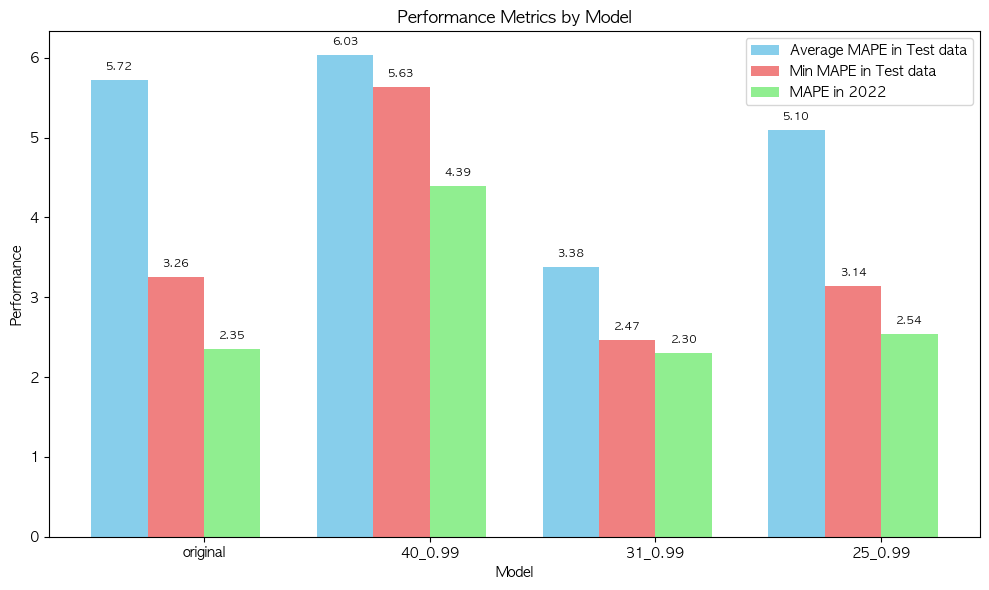

In [2]:
import matplotlib.pyplot as plt
import numpy as np

# 모델과 성능 지표 데이터
models = ['original', '40_0.99', '31_0.99', '25_0.99']
average_mape = [5.72, 6.03, 3.38, 5.10]
min_mape = [3.26, 5.63, 2.47, 3.14]
mape_2022 = [2.35, 4.39, 2.30, 2.54]

# 그래프 설정
bar_width = 0.25
index = np.arange(len(models))

# 시각화
plt.figure(figsize=(10, 6))

# 막대 그래프 생성
bar1 = plt.bar(index, average_mape, bar_width, label='Average MAPE in Test data', color='skyblue')
bar2 = plt.bar(index + bar_width, min_mape, bar_width, label='Min MAPE in Test data', color='lightcoral')
bar3 = plt.bar(index + 2 * bar_width, mape_2022, bar_width, label='MAPE in 2022', color='lightgreen')

# 막대 상단에 수치 표시
for bar, values in zip([bar1, bar2, bar3], [average_mape, min_mape, mape_2022]):
    for i, value in enumerate(values):
        plt.text(bar[i].get_x() + bar[i].get_width() / 2, bar[i].get_height() + 0.1,
                 f'{value:.2f}', ha='center', va='bottom', fontsize=8)

# 축 및 레이블 설정
plt.xlabel('Model')
plt.ylabel('Performance')
plt.title('Performance Metrics by Model')
plt.xticks(index + 1.5 * bar_width, models)
plt.legend()

# 그래프 표시
plt.tight_layout()
plt.show()


In [3]:
prediction_df = pd.read_csv("../../data/processed/prediction/population_result(2023-2060).csv", encoding='utf-8')
future_fetures_df = pd.read_csv('../../data/processed/distance_df/31_0.9(2010-2059).csv', encoding='utf-8')

In [4]:
prediction_df

,연도,행정구역,학령인구(명),시도
0,2023,강원특별자치도 강릉시,27734.0,강원특별자치도
1,2024,강원특별자치도 강릉시,26716.0,강원특별자치도
2,2025,강원특별자치도 강릉시,25644.0,강원특별자치도
3,2026,강원특별자치도 강릉시,24744.0,강원특별자치도
4,2027,강원특별자치도 강릉시,23729.0,강원특별자치도
...,...,...,...,...
8469,2056,충청북도 충주시,10173.0,충청북도
8470,2057,충청북도 충주시,9866.0,충청북도
8471,2058,충청북도 충주시,9572.0,충청북도
8472,2059,충청북도 충주시,9290.0,충청북도


In [5]:
def visualization_prediction_city(city):
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Get the corresponding 시도 for the entered 도시
    sido_for_city = prediction_df[prediction_df['행정구역'] == city_input]['시도'].iloc[0]

    # Iterate through each region in the 시도 
    for region in prediction_df[prediction_df['시도'] == sido_for_city]['행정구역'].unique().tolist():
        temp_df = prediction_df[prediction_df['행정구역'] == region]

        # 강조: 입력된 도시와 일치하면 굵은 선, 그렇지 않으면 얇은 선
        linewidth = 4 if region == city_input else 2

        # 강조: 입력된 도시와 일치하면 큰 마커, 그렇지 않으면 작은 마커
        markersize = 10 if region == city_input else 6

        # 강조: 입력된 도시와 일치하면 박스 표시
        edgecolor = 'red' if region == city_input else 'none'
        
        plt.plot(temp_df['연도'], temp_df['학령인구(명)'], label=region, marker='o', linestyle='-', linewidth=linewidth, markersize=markersize, markeredgecolor=edgecolor)

    # Add labels and title
    plt.xlabel('연도')
    plt.ylabel('학령인구(명)')
    plt.title(f'{sido_for_city} 학령인구 예측 (2023-2060)')

    # Add legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()

In [6]:
def visualization_future_data_city(city):
    # 시각화 시작
    plt.figure(figsize=(12, 8))
    plt.title(f"{city} - 데이터(2010-2059)")

    # 주어진 도시의 데이터 추출
    temp_df = future_fetures_df[future_fetures_df['행정구역'] == city]

    # Features 리스트 (학령인구를 포함한 다른 features들)
    features = ['총인구수(명)', '유치원 수', '초등학교 수', '출생건수', '사망건수', '혼인건수', '이혼건수', '학령인구(명)']

    # Color mapping for features
    color_mapping = {
        '총인구수(명)': 'b',
        '유치원 수': 'g',
        '초등학교 수': 'r',
        '출생건수': 'c',
        '사망건수': 'm',
        '혼인건수': 'y',
        '이혼건수': 'k',
        '학령인구(명)': 'purple'
    }

    for feature in features:        
        # 2022년까지의 실제 데이터 플로팅
        plt.plot(temp_df['연도'][:len(temp_df[temp_df['연도'] <= 2022])], temp_df[feature][:len(temp_df[temp_df['연도'] <= 2022])], label=f"Actual {feature}", marker='o', color=color_mapping[feature])
    
        # 2023년부터의 예측 데이터 플로팅
        plt.plot(temp_df['연도'][len(temp_df[temp_df['연도'] <= 2022]):], temp_df[feature][len(temp_df[temp_df['연도'] <= 2022]):], label=f"Predicted {feature}", linestyle='--', color=color_mapping[feature])

    plt.xlabel('연도')
    plt.ylabel('값')

    # 레전드를 플롯 밖으로 이동하여 고정
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # 그리드 추가
    plt.grid(True, linestyle='--', alpha=0.7)

    plt.show()


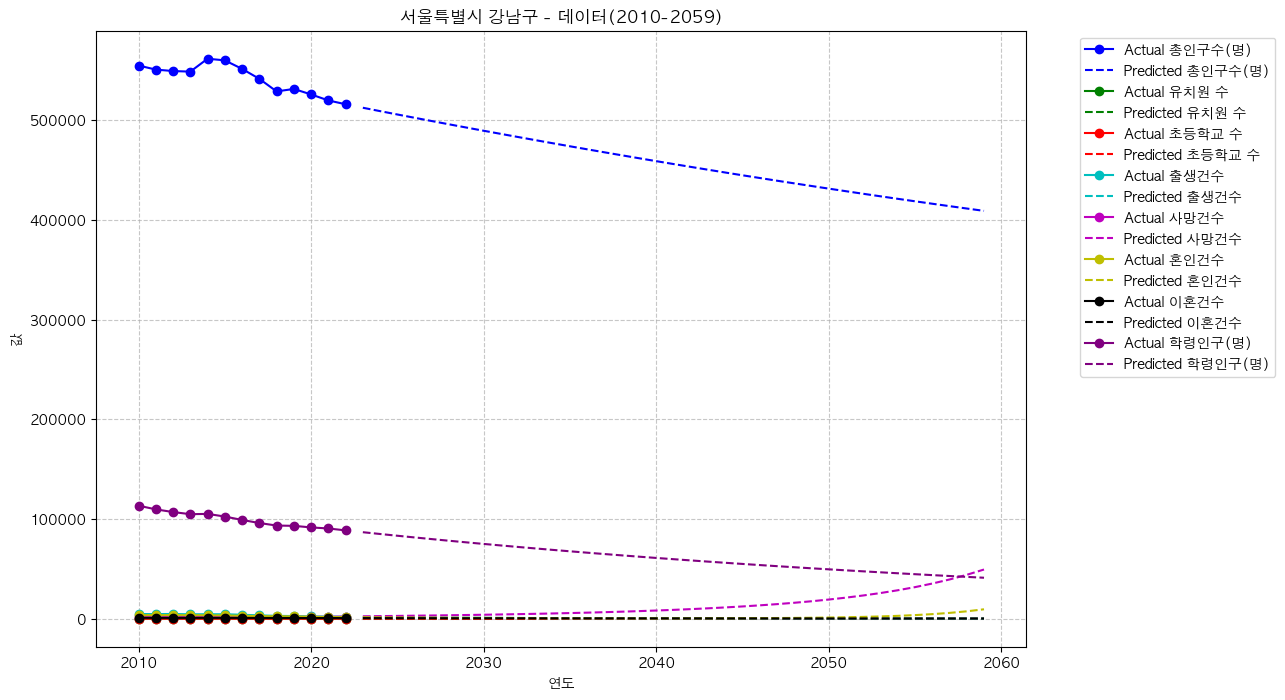

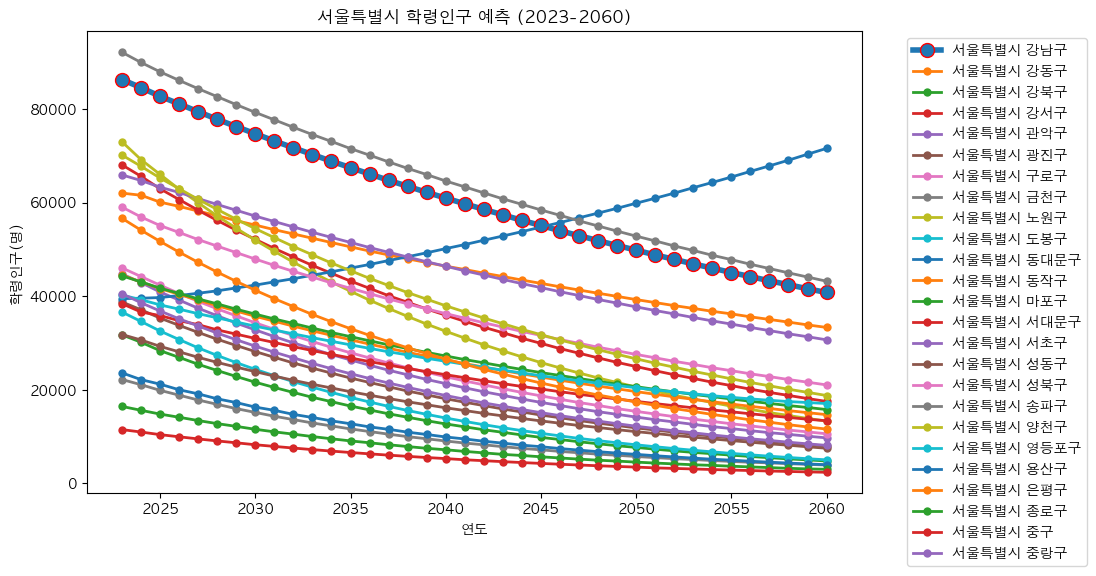

In [8]:
# 사용자로부터 도시 입력 받기
city_input = input("도시를 입력하세요: ")

# 해당 도시와 시도를 시각화
if city_input in prediction_df['행정구역'].unique():
    visualization_future_data_city(city_input)
    visualization_prediction_city(city_input)
    

else:
    print(f"{city_input}은(는) 데이터에 존재하지 않는 도시입니다.")


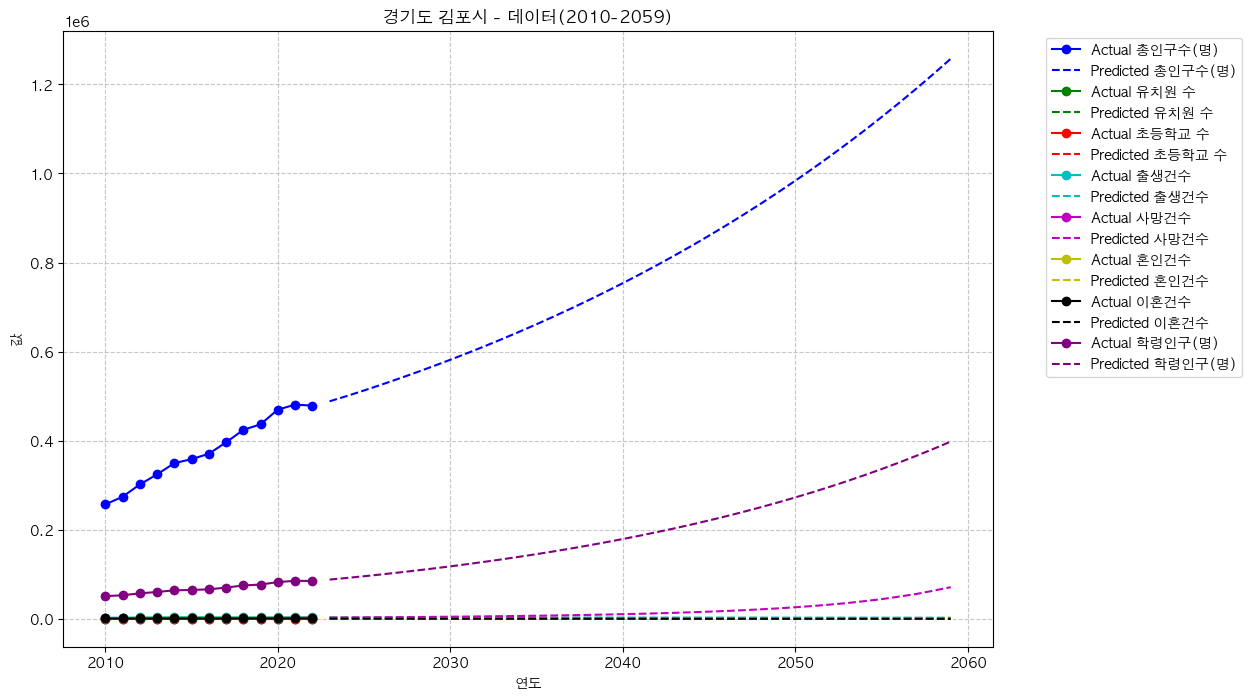

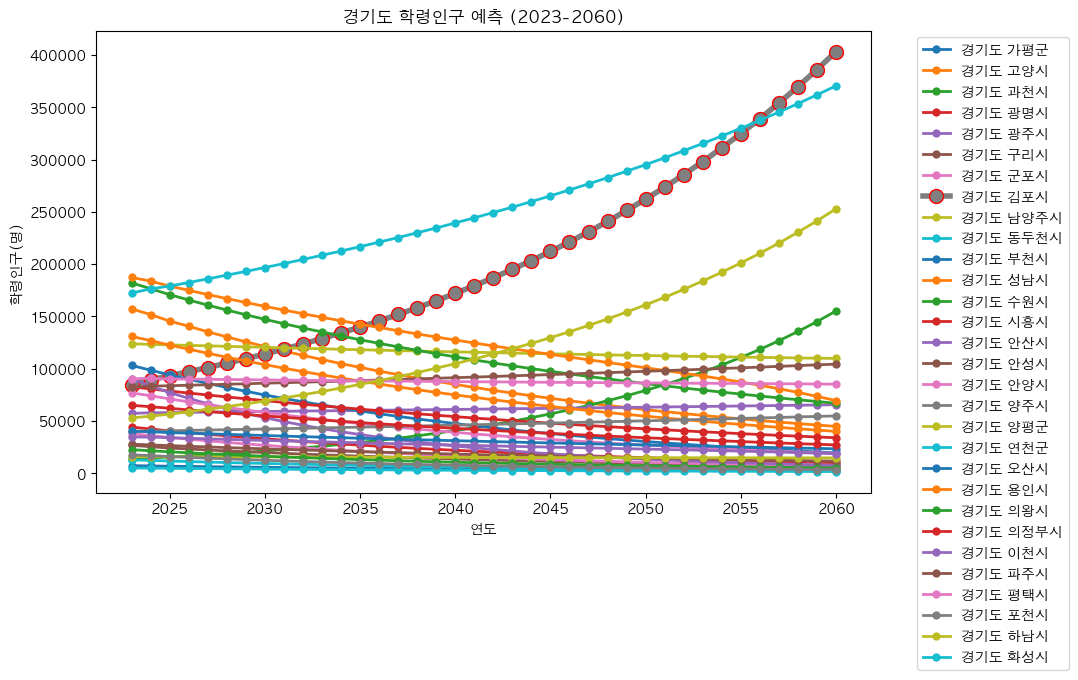

In [9]:
# 사용자로부터 도시 입력 받기
city_input = input("도시를 입력하세요: ")

# 해당 도시와 시도를 시각화
if city_input in prediction_df['행정구역'].unique():
    visualization_future_data_city(city_input)
    visualization_prediction_city(city_input)
    

else:
    print(f"{city_input}은(는) 데이터에 존재하지 않는 도시입니다.")


In [15]:
df = pd.read_csv('../../data/processed/no_NaN_dataset_final.csv', encoding='utf-8')
merge_df = pd.concat([df, prediction_df])
use_col  =['행정구역', '연도', '학령인구(명)']
merge_df = merge_df[use_col]
merge_df.sort_values(by=['행정구역', '연도'], inplace=True)
merge_df['시도'] = merge_df['행정구역'].apply(lambda x: x.split()[0])

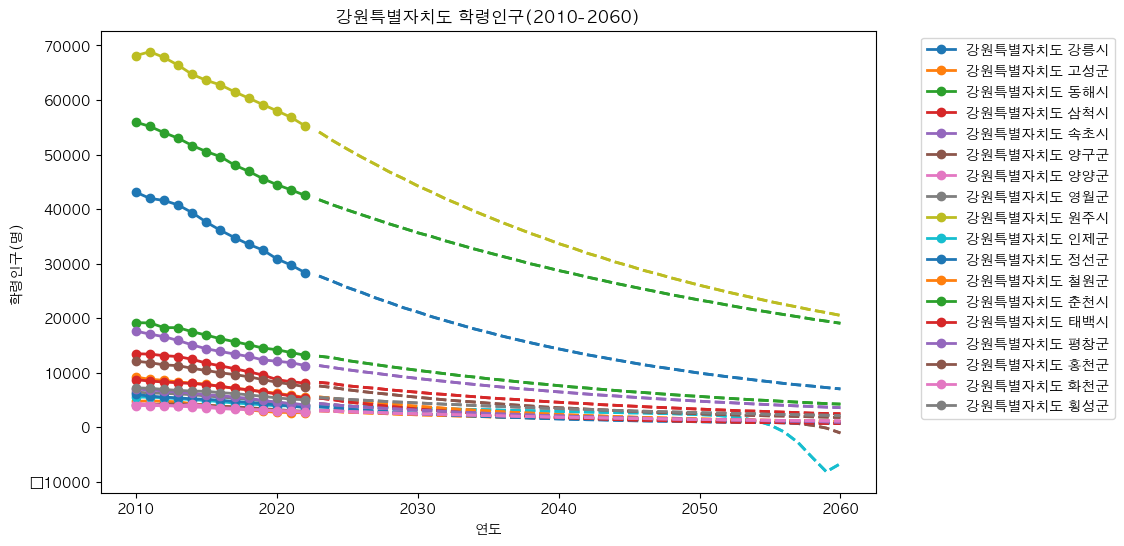

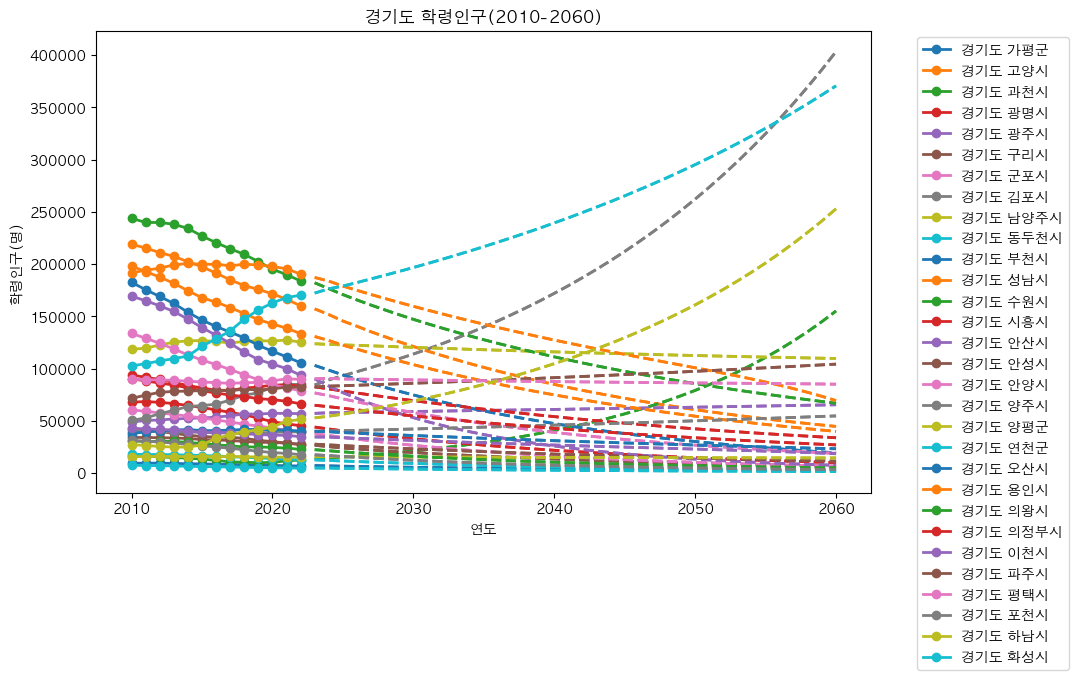

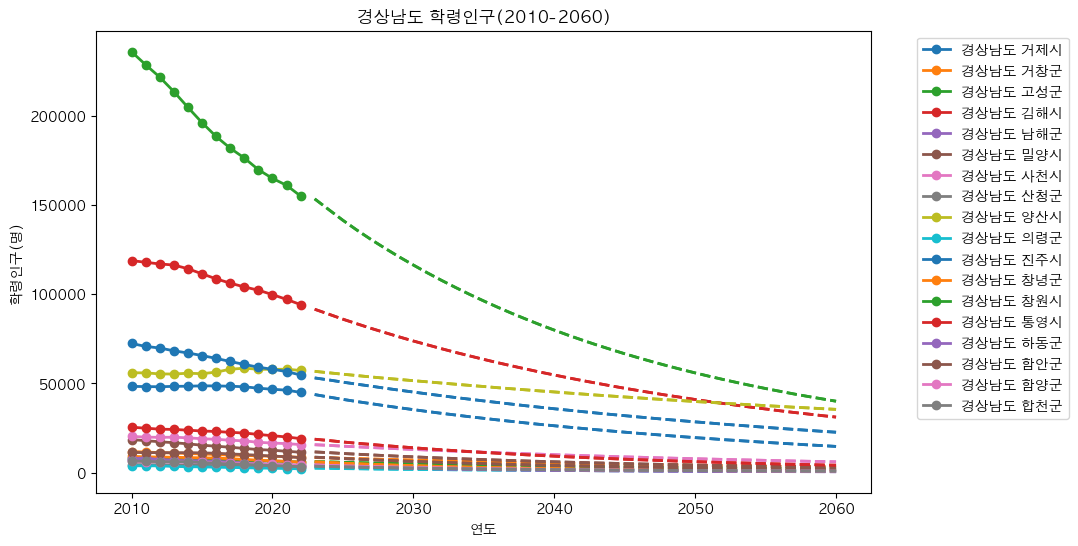

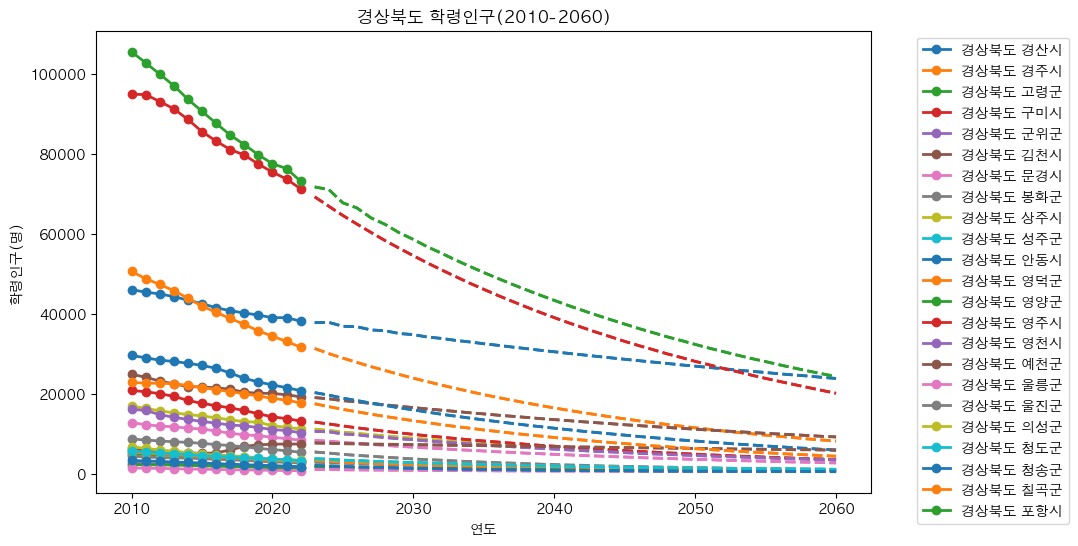

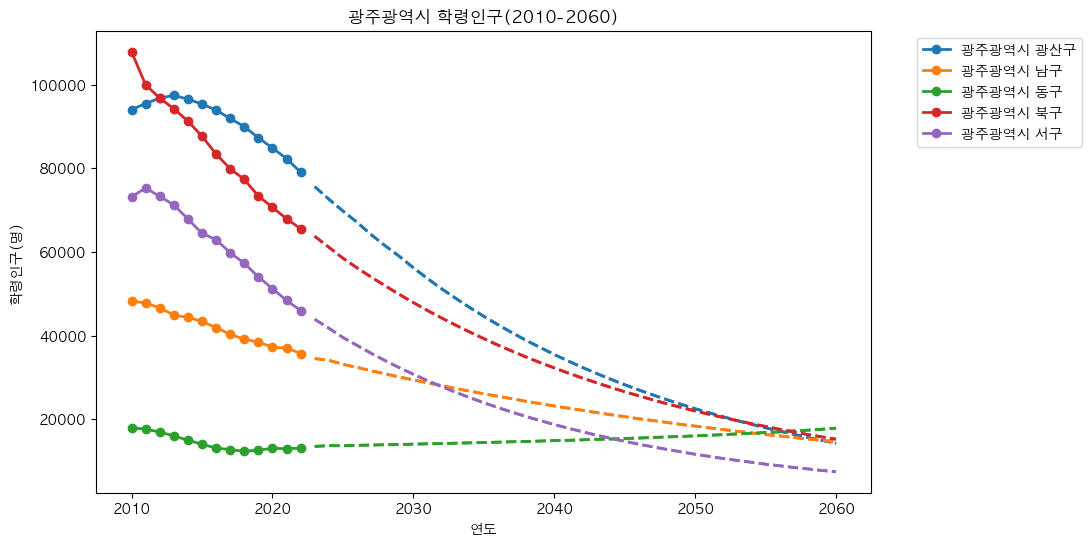

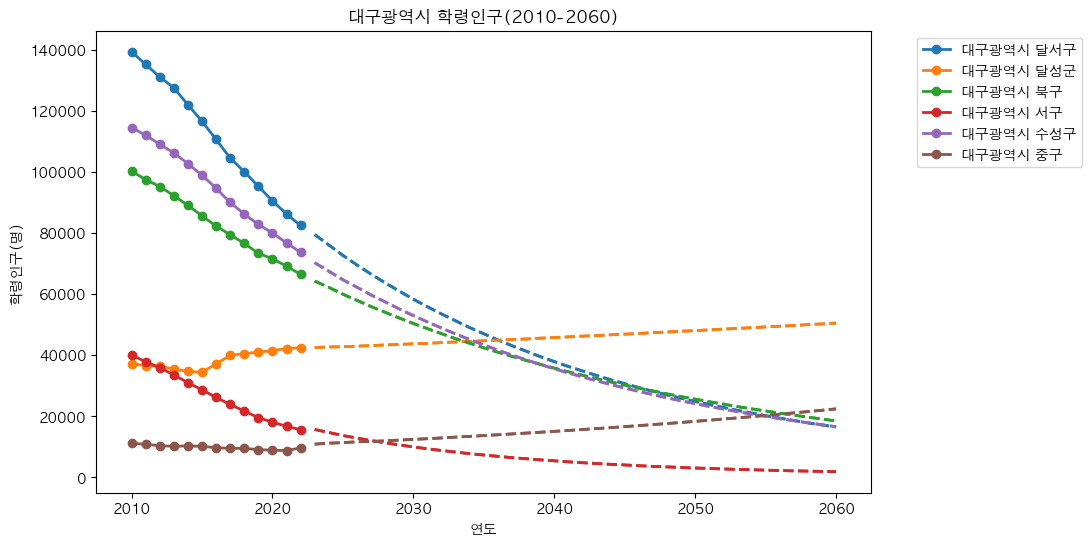

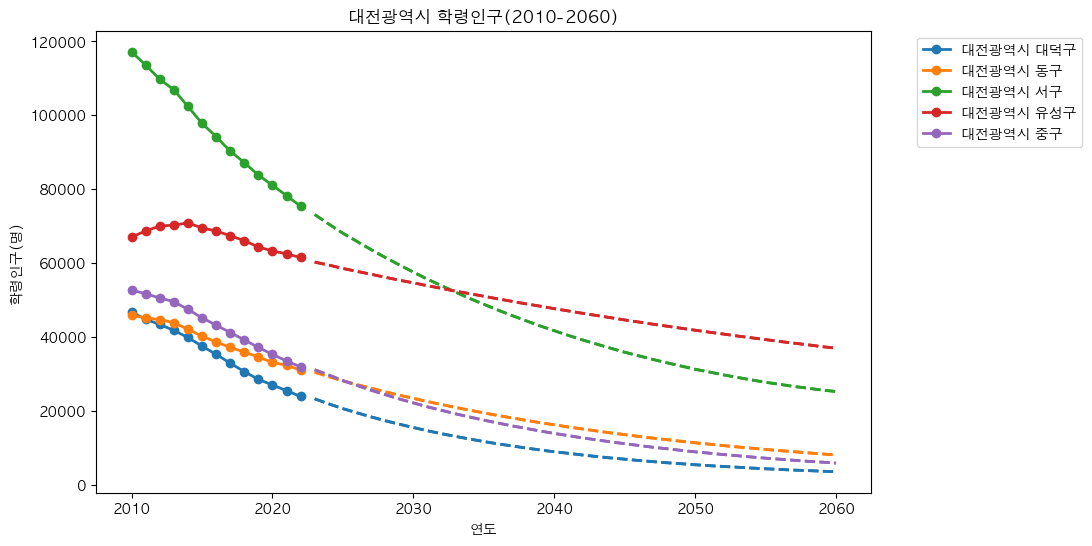

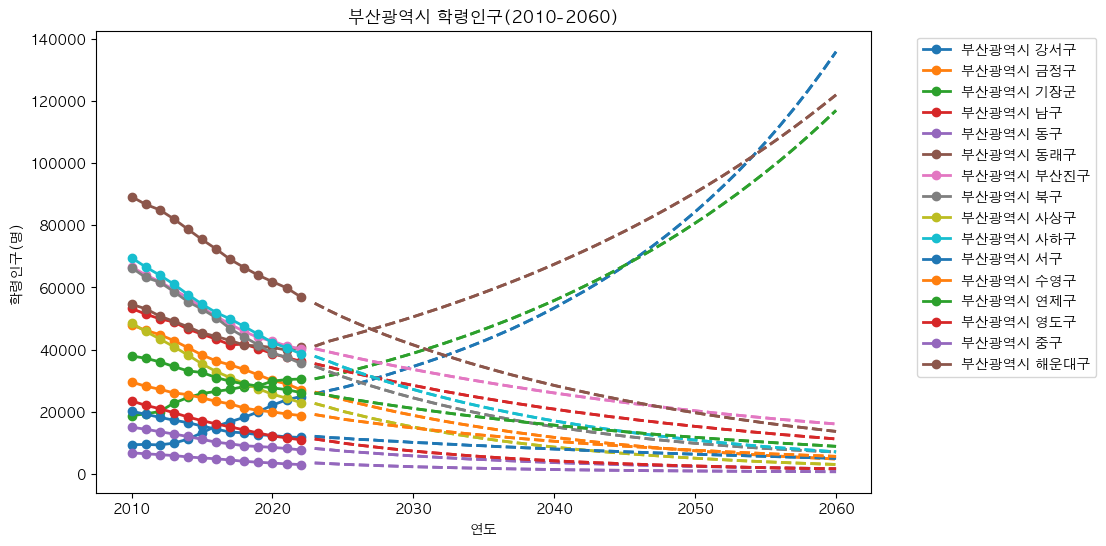

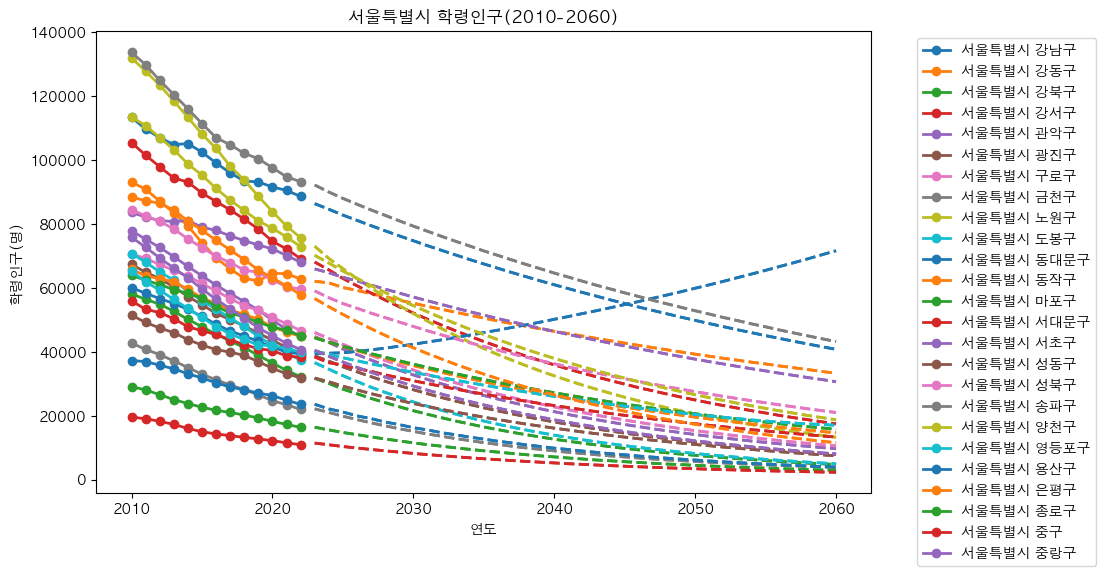

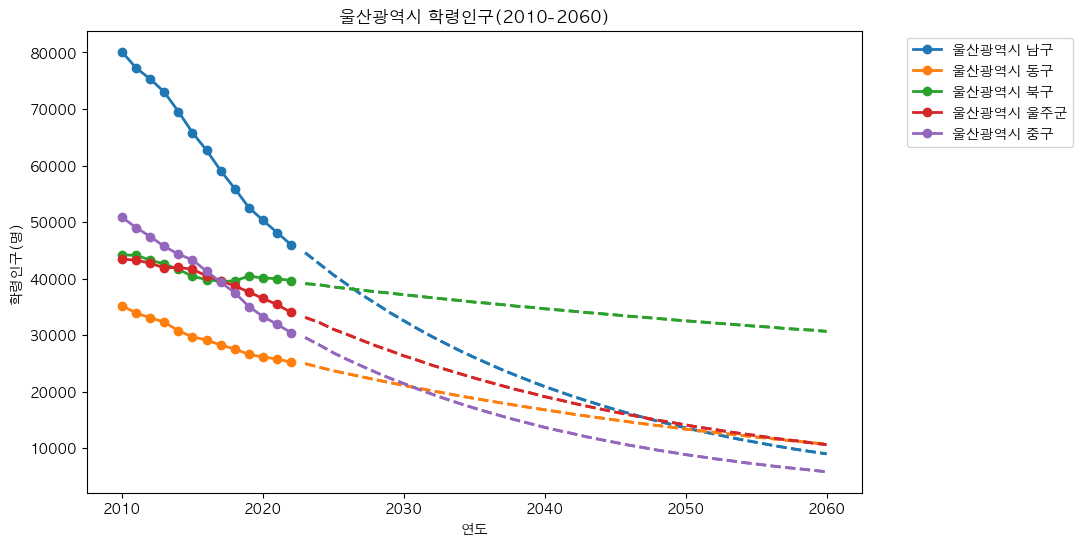

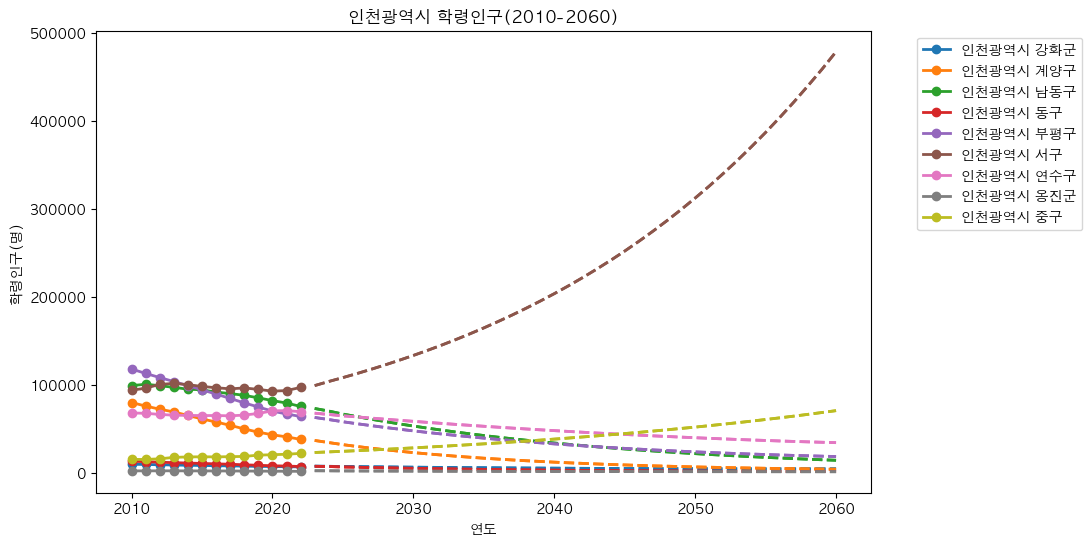

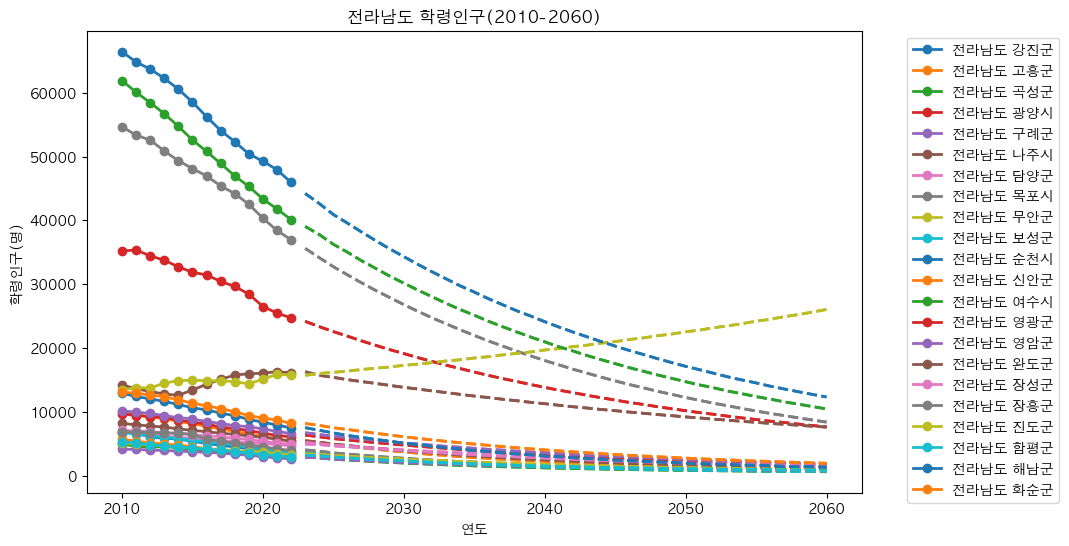

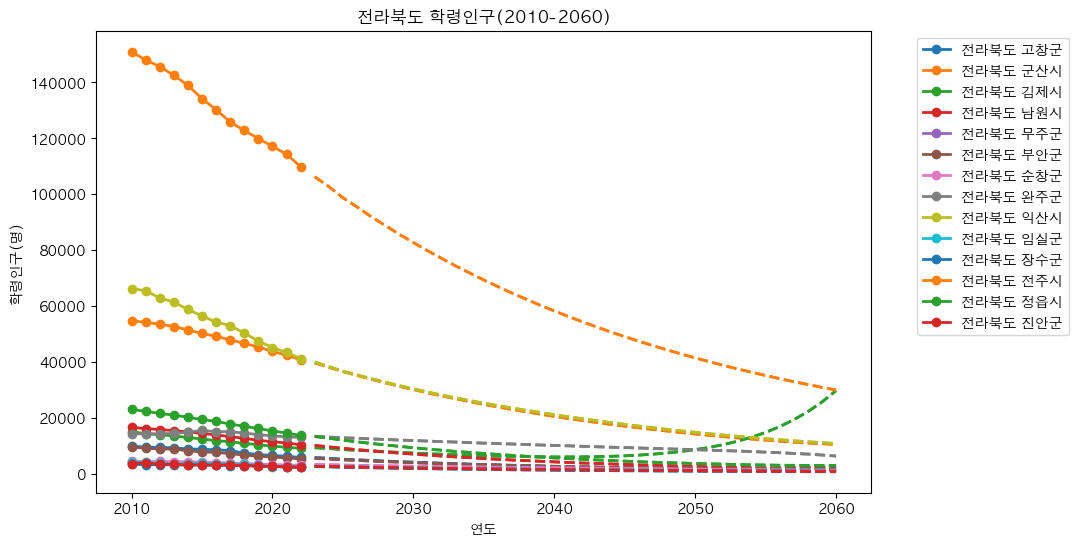

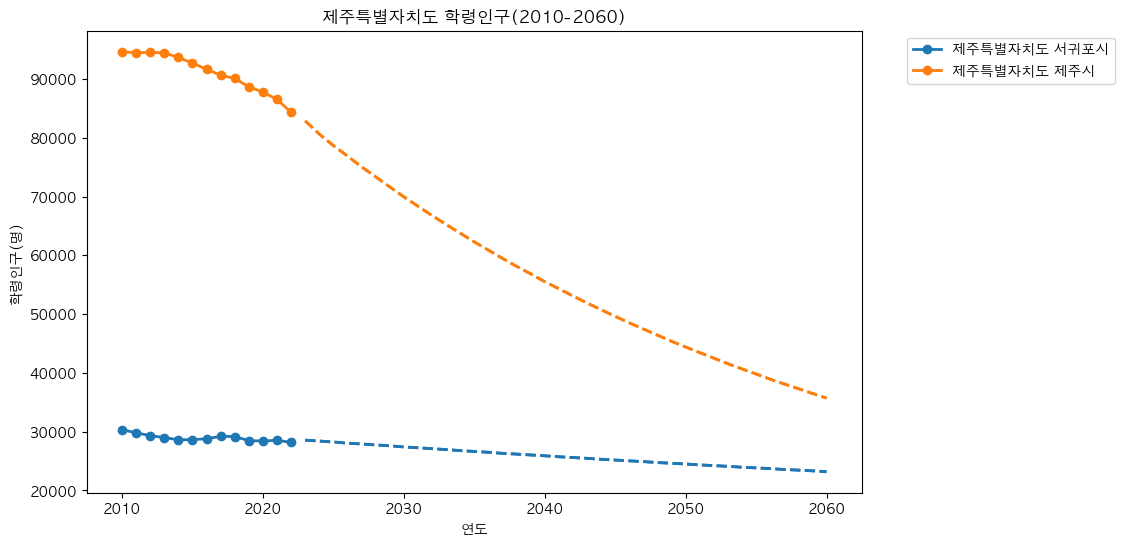

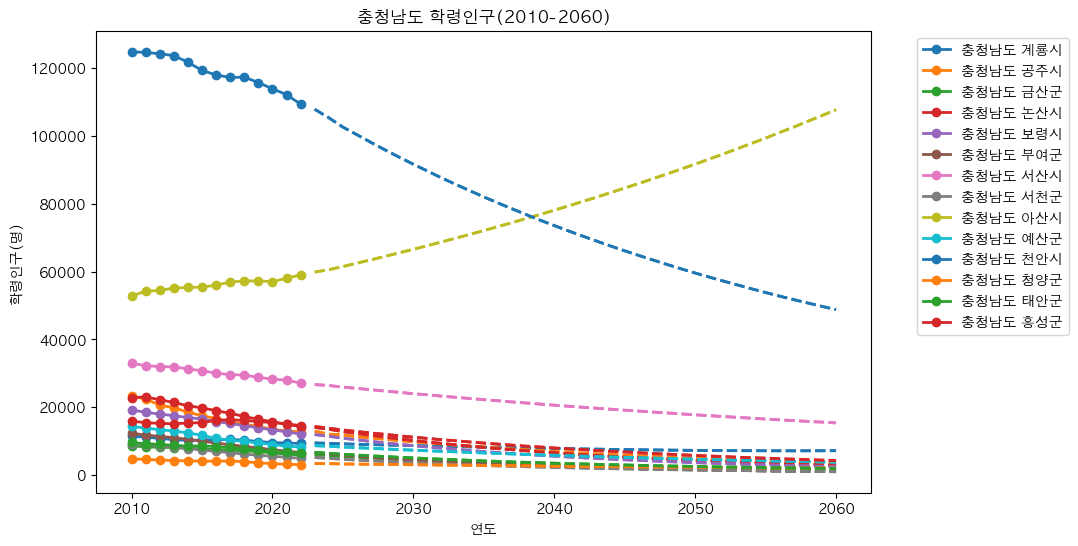

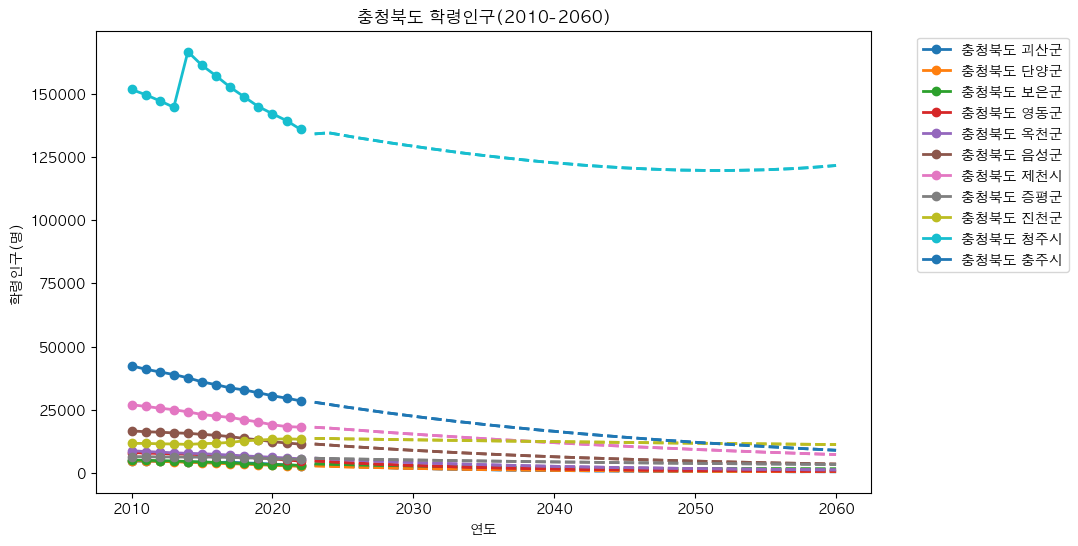

In [16]:
import matplotlib.pyplot as plt

for sido in merge_df['시도'].unique().tolist():
    # Create a new figure
    plt.figure(figsize=(10, 6))

    # Iterate through each region
    for region in merge_df[merge_df['시도'] == sido]['행정구역'].unique().tolist():
        temp_df = merge_df[merge_df['행정구역'] == region]
        future_df = prediction_df[prediction_df['행정구역'] == region]
        
        # Plotting historical data before 2023
        plt.plot(temp_df['연도'][:len(temp_df[temp_df['연도'] <= 2022])], 
                 temp_df['학령인구(명)'][:len(temp_df[temp_df['연도'] <= 2022])], 
                 marker='o', linestyle='-', linewidth=2, label=f'{region}')
        
        # Plotting dashed line for historical data from 2023 onwards
        plt.plot(temp_df['연도'][len(temp_df[temp_df['연도'] <= 2022]):], 
                 temp_df['학령인구(명)'][len(temp_df[temp_df['연도'] <= 2022]):], 
                 linestyle='--', color=plt.gca().lines[-1].get_color(), linewidth=2)
    
        # Plotting predicted data from 2023 onwards
        plt.plot(range(2023, 2061), future_df['학령인구(명)'], linestyle='--', 
                 color=plt.gca().lines[-1].get_color(), linewidth=2)
    
    # Add labels and title
    plt.xlabel('연도')
    plt.ylabel('학령인구(명)')
    plt.title(f'{sido} 학령인구(2010-2060)')

    # Add legend outside the plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Display the plot
    plt.show()
